# Bayesian Optimisation

For black-box optimisation i.e. find the minimum of an unknown function $f$ which is expensive to evaluate. BO learns a GP as a surrogate function and uses our belief in this surrogate as a guide to our search offering improvements over random search.

Objective: $ \hat{x} = argmin_xf(x) $

GP predictive posterior: $ p(f_*|\mathcal{D},x_*,\theta) = \mathcal{N}(\mu_{x_*|x}, K_{x_*|x}) $ where $ \mathcal{D}=\{x,f\} $, the observed data.

The acquisition function $\alpha$ encodes the strategy of how to utilise our knowledge about the unknown function (via our belief in the surrogate) in order to decide where to next query the function. The acquisition function needs to be cheap to evaluate and should balance exploration and exploitation.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import norm

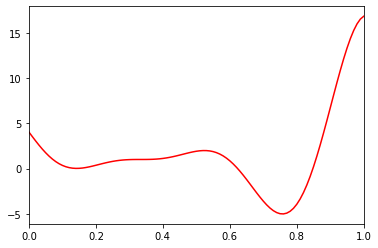

In [40]:
def func(A=1, B=0, C=0):
    return lambda x: A*(6*x-2)**2*np.sin(12*x-4) + B*(x-0.5) + C
f = func(C=1)

x_star = np.linspace(0, 1, 101).reshape(-1, 1)
fig, ax = plt.subplots()
ax.plot(x_star, f(x_star), c='r')
ax.set_xlim(0, 1)
plt.show()

### Random search

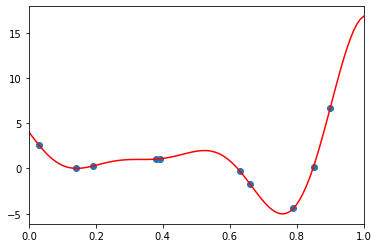

Minimum at 0.79 with value -4.4


In [41]:
n = 10
np.random.seed(10)
index = np.random.permutation(len(x_star))[:n]
x_ran = x_star[index].reshape(-1, 1)
f_ran = f(x_ran)

x_star = np.linspace(0, 1, 100).reshape(-1, 1)
fig, ax = plt.subplots()
ax.plot(x_star, f(x_star), c='r')
ax.scatter(x_ran, f_ran)
ax.set_xlim(0, 1)
plt.show()

print(f'Minimum at {round(x_ran[np.argmin(f_ran)].item(), 2)} with value {round(np.min(f_ran), 2)}')

### Bayesian Optimisation

In [42]:
def squared_exponential(var, l):
    return lambda x1, x2: var * np.exp(-np.power(cdist(x1, x2), 2) / l**2)

# kernel hyperparams: var, length, noise
theta = [5, 0.1, 0.1]

x_initial = np.array([[0.35]])

def surrogate_belief(x, f, x_star, theta):
    var, l, noise = theta[0], theta[1], theta[2]
    kernel = squared_exponential(var, l)
    mu_star = kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + noise * np.identity(len(x))) @ f
    varSigma_star = kernel(x_star, x_star) - kernel(x_star, x) @ np.linalg.inv(kernel(x, x) + noise * np.identity(len(x))) @ kernel(x, x_star)
    return mu_star, varSigma_star

def plot_surrogate(mu, var, x, alpha, x_next, alpha_next, scale=1):
    fig, ax = plt.subplots()
    ax.scatter(x, f(x))
    ax.plot(x_star, f(x_star), c='r', label='unknown function')
    ax.plot(x_star, mu, c='cyan', label='GP surrogate (2 std)')
    ax.fill_between(x_star.flatten(), mu.flatten() - 2*np.sqrt(np.diag(var)).flatten(),
                    mu.flatten() + 2*np.sqrt(np.diag(var)).flatten(), alpha=0.3, color='cyan')

    ax.plot(x_star, scale*alpha, c='m', label='acquisition function')
    ax.scatter(x_next, scale*alpha_next, c='m', marker='x')

    ax.set_xlim(0, 1)
    ax.legend()
    plt.show()

1) Thompson samping

Draw a sample from the GP posterior and find the minimum: $ -\alpha(x) \sim p(f|\mathcal{D},x, \theta)$

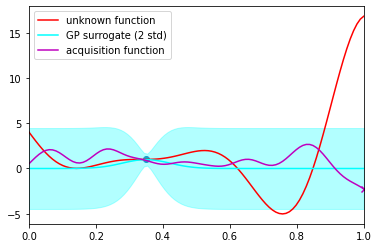

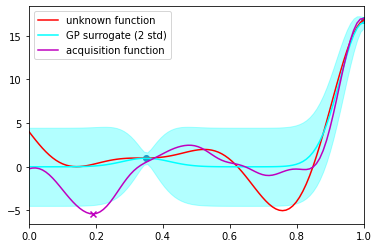

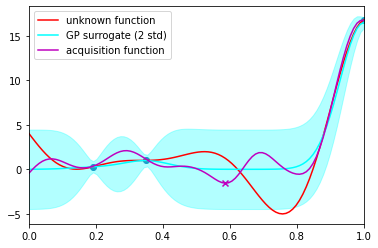

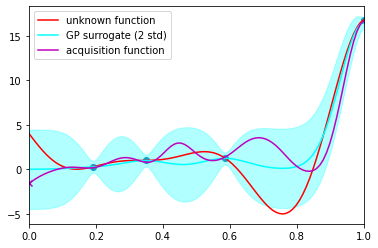

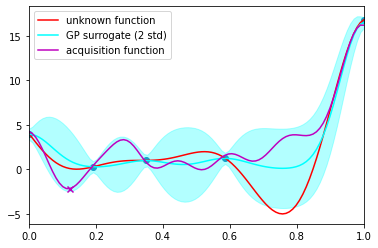

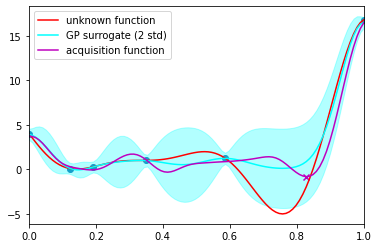

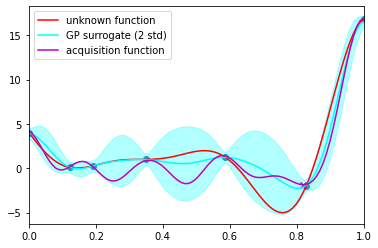

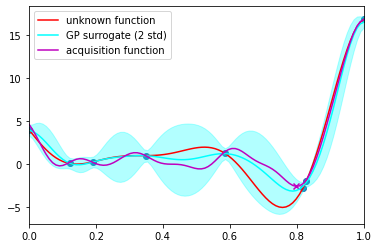

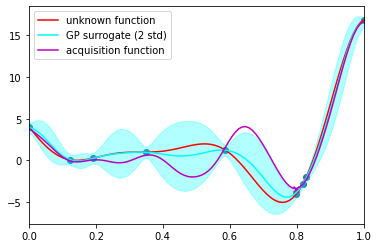

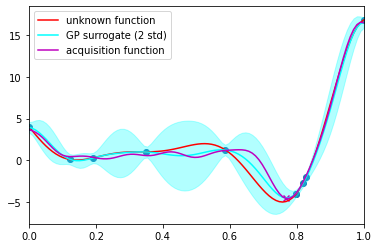

Minimum at 0.8 with value -4.05


In [48]:
def thompson_samping(mu, var):
    return np.random.multivariate_normal(mu.flatten(), var, 1).reshape(-1, 1)

x = x_initial
for i in range(n):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = thompson_samping(mu, var)
    x_next = x_star[np.argmin(alpha)].reshape(-1, 1)
    alpha_next = np.min(alpha)
    plot_surrogate(mu, var, x, alpha, x_next, alpha_next)
    if i != n - 1:
        x = np.concatenate((x, x_next))
print(f'Minimum at {round(x[np.argmin(f(x))].item(), 2)} with value {round(np.min(f(x)), 2)}')

2) Upper confidence bound (UCB)

Linear combination of GP mean and variance: $ \alpha(x) = -\mu(x) + \beta \sigma(x) $

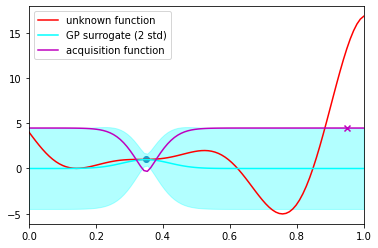

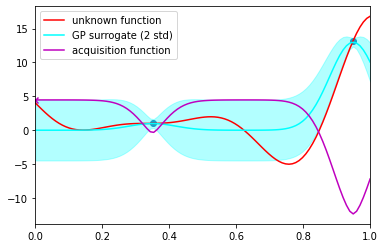

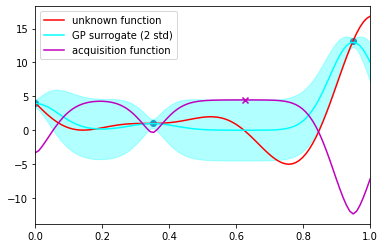

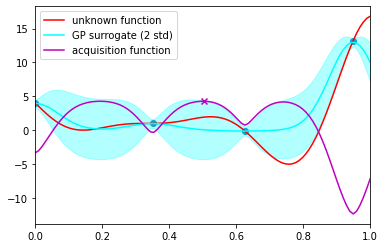

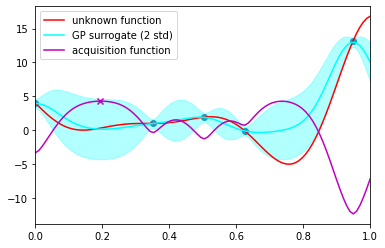

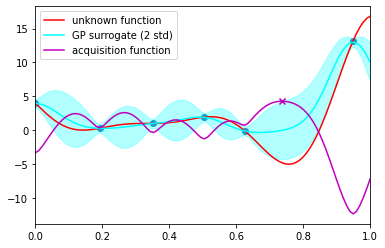

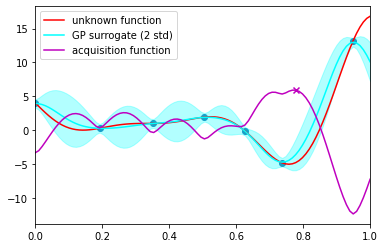

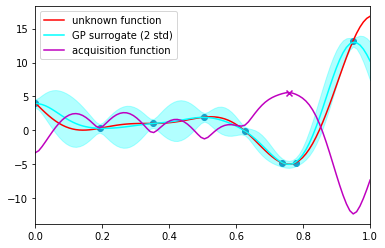

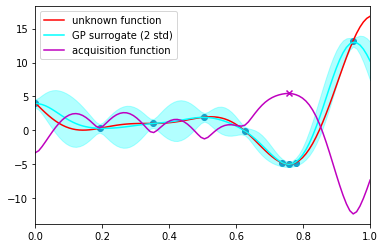

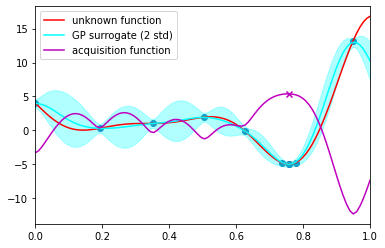

Minimum at 0.76 with value -5.02


In [49]:
def ucb(mu, var, beta=1):
    return -mu.flatten() + beta * np.sqrt(np.diag(var))

x = x_initial
for i in range(n):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    alpha = ucb(mu, var, beta=2)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    alpha_next = np.max(alpha)
    plot_surrogate(mu, var, x, alpha, x_next, alpha_next)
    if i != n - 1:
        x = np.concatenate((x, x_next))
print(f'Minimum at {round(x[np.argmin(f(x))].item(), 2)} with value {round(np.min(f(x)), 2)}')

3. Probability of improvement

Define a utility function: $u(x)=1$ if $f(x) \leq f(x^*)$ else $0$ where $f(x^*)$ is the current best estimate (observation or posterior mean)

Acquisition function is the expected utility: $ \alpha = \mathbb{E}[u(x)] = p(f(x) \leq f(x^*) = \int_{-\infty}^{f(x^*)} \mathcal{N}(f|\mu(x),K(x,x))\ df = \Phi(f(x^*)|\mu(x),K(x,x)) $ where $\Phi$ is the cumulative density function (cdf) of the Gaussian

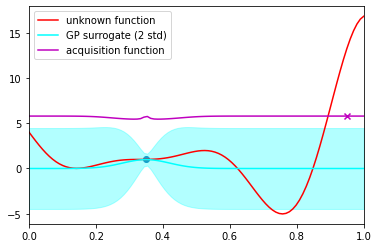

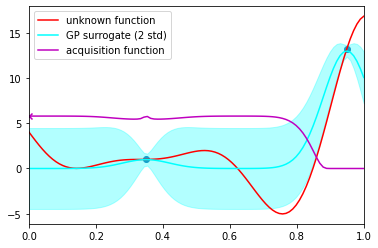

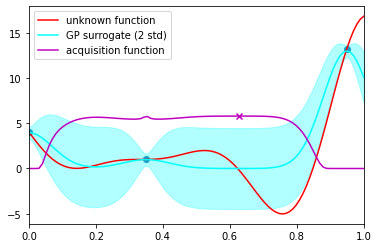

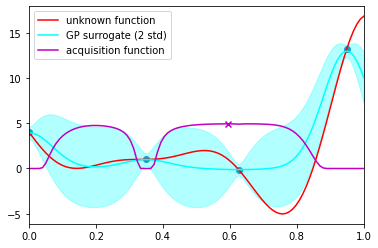

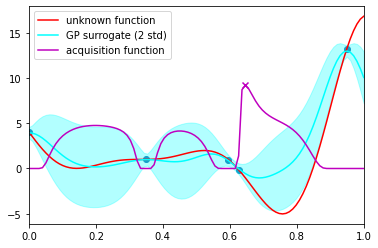

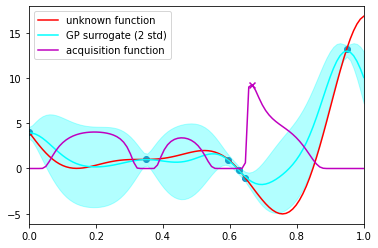

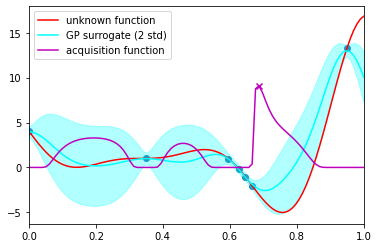

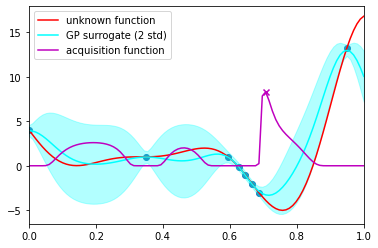

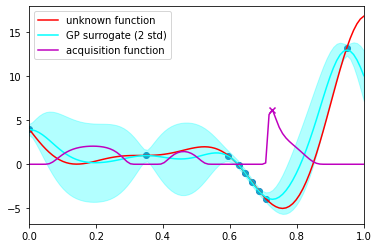

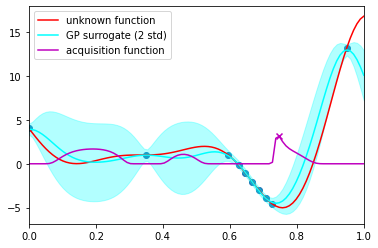

Minimum at 0.73 with value -4.59


In [50]:
def prob_improvement(mu, var, f_best):
    return norm.cdf(f_best, mu.flatten(), np.diag(var)).flatten()

x = x_initial
for i in range(n):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    f_best = np.min(f(x))
    alpha = prob_improvement(mu, var, f_best)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    alpha_next = np.max(alpha)
    plot_surrogate(mu, var, x, alpha, x_next, alpha_next, scale=10)
    if i != n - 1:
        x = np.concatenate((x, x_next))
print(f'Minimum at {round(x[np.argmin(f(x))].item(), 2)} with value {round(np.min(f(x)), 2)}')

4) Expected Improvement

Utility is proportional to expected improved $u(x)=max(0,f(x^*)-f(x)$

$ \alpha(x) = \int_{-\infty}^{f(x^*)} (f(x^*)-f) \mathcal{N}(f|\mu(x),K(x,x))\ df = (f(x^*)-\mu(x)) \Phi(f(x^*)|\mu(x),K(x,x)) + K(x,x) \mathcal{N}(f(x^*)|\mu(x),K(x,x)) $

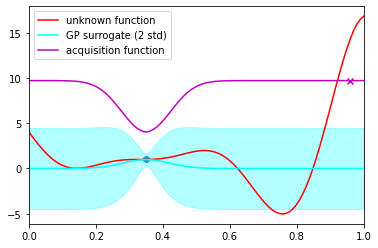

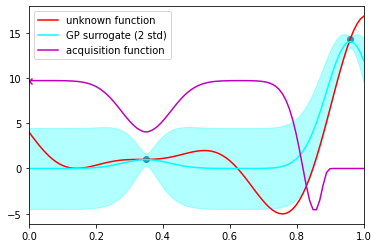

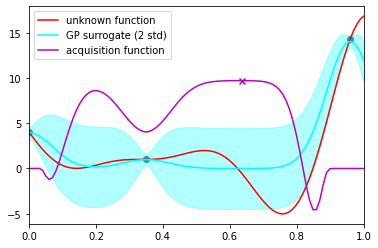

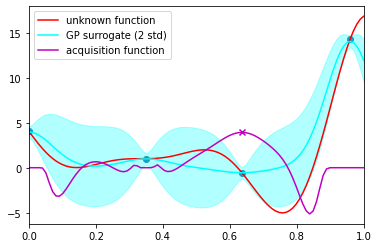

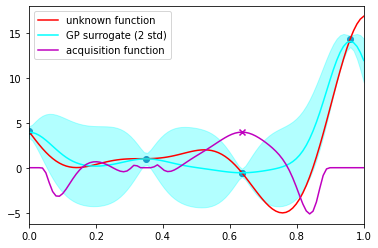

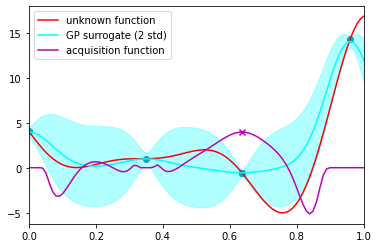

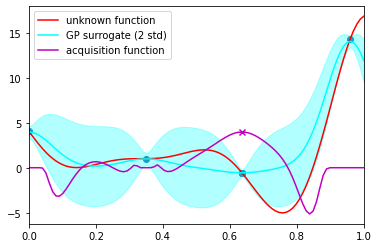

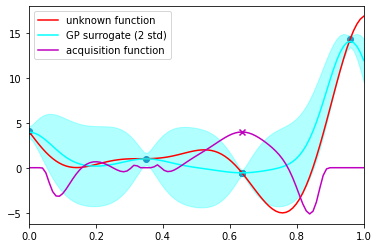

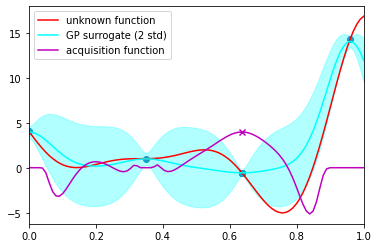

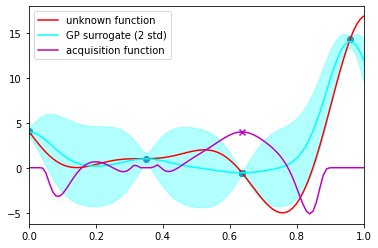

Minimum at 0.64 with value -0.57


In [51]:
def expected_improvement(mu, var, f_best):
    exploit = (f_best - mu.flatten()) * norm.cdf(f_best, mu.flatten(), np.diag(var))
    explore = np.diag(var) * norm.pdf(f_best, mu.flatten(), np.diag(var))
    return (exploit + explore).flatten()

x = x_initial
for i in range(n):
    mu, var = surrogate_belief(x, f(x), x_star, theta)
    f_best = np.min(f(x))
    alpha = expected_improvement(mu, var, f_best)
    x_next = x_star[np.argmax(alpha)].reshape(-1, 1)
    alpha_next = np.max(alpha)
    plot_surrogate(mu, var, x, alpha, x_next, alpha_next, scale=10)
    if i != n - 1:
        x = np.concatenate((x, x_next))
print(f'Minimum at {round(x[np.argmin(f(x))].item(), 2)} with value {round(np.min(f(x)), 2)}')